# Newton method


In [1]:
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# We enable double precision in JAX
jax.config.update("jax_enable_x64", True)

We consider a random matrix $A \in \mathbb{R}^{n\times n}$, with $n = 100$ and a random vector $\mathbf{x}_{\text{ex}} \in \mathbb{R}^n$.
We define then $\mathbf{b} = A \, \mathbf{x}_{\text{ex}}$.


In [2]:
n = 100

np.random.seed(0)
A = np.random.randn(n, n)
x_ex = np.random.randn(n)
b = A @ x_ex

Define the loss function

$$
\mathcal{L}(\mathbf{x}) = \| \mathbf{b} - A \, \mathbf{x} \|_2^2
$$


In [3]:
def loss(x):
    return jnp.sum(jnp.square(A @ x - b))


print(loss(x_ex))

0.0


By using the `jax` library, implement and compile functins returning the gradient ($\nabla \mathcal{J}(\mathbf{x})$) and the hessian ($\nabla^2 \mathcal{J}(\mathbf{x})$) of the loss function.


In [4]:
grad = jax.grad(loss)
hess = jax.jacfwd(jax.jacrev(loss))

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

Check that the results are correct (up to machine precision).


In [5]:
np.random.seed(0)
x_guess = np.random.randn(n)

G_ad = grad_jit(x_guess)
G_ex = 2 * A.T @ (A @ x_guess - b)
print(np.linalg.norm(G_ad - G_ex))

H_ad = hess_jit(x_guess)
H_ex = 2 * A.T @ A
print(np.linalg.norm(H_ad - H_ex))

9.707921159164663e-13
0.0


Exploit the formula

$$
\nabla^2 \mathcal{J}(\mathbf{x}) \mathbf{v} = \nabla_{\mathbf{x}} \phi(\mathbf{x}, \mathbf{v})
$$

where

$$
\phi(\mathbf{x}, \mathbf{v}) := \nabla \mathcal{J}(\mathbf{x}) \cdot \mathbf{v}
$$

to write an optimized function returning the hessian-vector-product

$$
(\mathbf{x}, \mathbf{v}) \mapsto \nabla^2 \mathcal{J}(\mathbf{x}) \mathbf{v}.
$$

Compare the computational performance w.r.t. the full hessian computation.


In [6]:
np.random.seed(1)
v = np.random.randn(n)

def hvp_basic(x, v):
    return hess(x) @ v
def gvp(x, v):
    return jnp.dot(grad(x), v)
def hvp(x, v):
    return jax.grad(gvp, argnums=0)(x, v)

hvp_basic_jit = jax.jit(hvp_basic)
hvp_jit = jax.jit(hvp)

Hv_ad = hvp_jit(x_guess, v)
Hv_ex = H_ex @ v
print(np.linalg.norm(Hv_ad - Hv_ex))

1.5923499043932032e-12


In [7]:
%timeit hvp_basic_jit(x_guess, v)
%timeit hvp_jit(x_guess, v)

65.1 μs ± 1.36 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
7.65 μs ± 146 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Implement the Newton method for the minimization of the loss function $\mathcal{L}$. Set a maximim number of 100 iterations and a tolerance on the increment norm of $\epsilon = 10^{-8}$.


In [9]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

elapsed_time = 0

for epoch in range(num_epochs):
    t0 = time.time()
    G = grad_jit(x)
    H = hess_jit(x)
    incr = -np.linalg.solve(H, G)

    elapsed_time += time.time() - t0
    x += incr

    print(f"============ epoch {epoch}")
    print(f"loss: {loss_jit(x):1.3e}")
    print(f"grad: {np.linalg.norm(G):1.3e}")
    print(f"incr: {np.linalg.norm(incr):1.3e}")

    if np.linalg.norm(incr) < eps:
        break

print(f"Elapsed time: {elapsed_time:.4f} [s]")
rel_err = np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)
print(f"Relative error: {rel_err:1.3e}")

============ epoch 0
loss: 8.335e-23
grad: 6.026e+03
incr: 1.548e+01
============ epoch 1
loss: 7.787e-28
grad: 3.771e-12
incr: 9.077e-10
Elapsed time: 0.0018 [s]
Relative error: 2.585e-14


In [11]:
def conjugate_gradient(matvec_fn, b, tol=1e-12, max_iter=1000):
    """
    Conjugate Gradient Solver for Ax = b, where A is only accessible via matvec_fn.
    """
    x = jnp.zeros_like(b)
    r = b - matvec_fn(x)  # Residual
    p = r
    rsold = jnp.dot(r, r)

    for _ in range(max_iter):
        Ap = matvec_fn(p)
        alpha = rsold / jnp.dot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rsnew = jnp.dot(r, r)
        if jnp.sqrt(rsnew) < tol:
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew
    return x


x = x_guess.copy()
num_epochs = 100
eps = 1e-8

elapsed_time = 0

for epoch in range(num_epochs):
    t0 = time.time()
    # FILL HERE: compute the gradient `G` and the increment `incr` by using the CG
    #            you should never compute explicitly the hessian
    G = grad_jit(x)
    incr = conjugate_gradient(lambda v: hvp_jit(x, v), -G)
    
    elapsed_time += time.time() - t0
    x += incr

    print(f"============ epoch{epoch}")
    print(f"loss: {loss_jit(x):1.3e}")
    print(f"grad: {np.linalg.norm(G):1.3e}")
    print(f"incr: {np.linalg.norm(incr):1.3e}")

    if np.linalg.norm(incr) < eps:
        break

print(f"Elapsed time: {elapsed_time:.4f} [s]")
rel_err = np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)
print(f"Relative error: {rel_err:1.3e}")

============ epoch0
loss: 6.850e-24
grad: 6.026e+03
incr: 1.548e+01
============ epoch1
loss: 6.644e-24
grad: 4.355e-12
incr: 3.349e-13
Elapsed time: 0.1268 [s]
Relative error: 2.716e-11


Repeat the optimization loop for the loss function

$$
\mathcal{L}(\mathbf{x}) = \| \mathbf{b} - A \, \mathbf{x} \|_4^4
$$


In [12]:
def loss(x):
    return jnp.sum((A @ x - b) ** 4)


grad = jax.grad(loss)
hess = jax.jacfwd(jax.jacrev(loss))

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

convergence reached!
epochs: 100
relative error: 1.657e-09


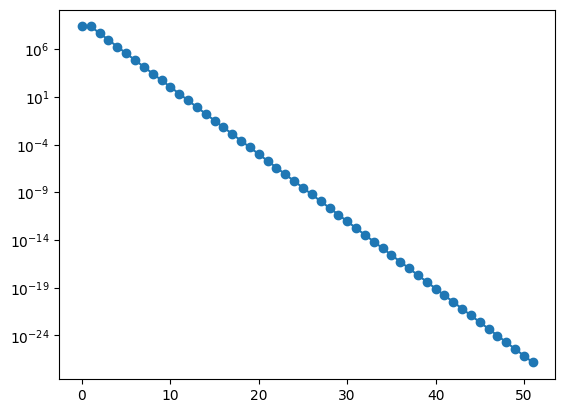

In [13]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

hist = [loss_jit(x)]
t0 = time.time()
for _ in range(num_epochs):
    l = loss_jit(x)
    hist.append(l)
    H = hess_jit(x)
    G = grad_jit(x)
    incr = np.linalg.solve(H, -G)
    x += incr
    if np.linalg.norm(incr) < eps:
        print("convergence reached!")
        break
ttot = time.time() - t0

plt.semilogy(hist, "o-")
print(f"epochs: {num_epochs}")
print("relative error: %1.3e" % (np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)))

# Quasi-Newton Optimization with BFGS Update

This algorithm minimizes an objective function $ f(\mathbf{x}) $ using a quasi-Newton method with the BFGS update. The goal is to iteratively update the solution $ \mathbf{x} $ and approximate the inverse Hessian until convergence criteria are met.

## Algorithm

1. **Initialization**:

   - Set the initial guess $ \mathbf{x} = \mathbf{x}\_{\text{guess}} $.
   - Let $ \mathbf{I} $ be the identity matrix, and initialize $ B^{-1} = \mathbf{I} $.
   - Compute the initial gradient $ \nabla f = \nabla f(\mathbf{x}\_{\text{guess}}) $.
   - Initialize the loss history: $ \text{history} = [f(\mathbf{x}_{\text{guess}})] $.
   - Set $ \text{epoch} = 0 $.

   $$
   B^{-1} = \mathbf{I}, \quad \nabla f = \nabla f(\mathbf{x}_{\text{guess}}), \quad \text{history} = [f(\mathbf{x}_{\text{guess}})]
   $$

2. **Iterative Updates**:

   - While $ \|\nabla f\| > \text{tol} $ and $ \text{epoch} < \text{max\_epochs} $:

     - Increment the epoch counter:

       $$
       \text{epoch} \leftarrow \text{epoch} + 1
       $$

     - Compute the search direction:

       $$
       \mathbf{p} = -B^{-1} \nabla f
       $$

     - Perform a line search to find the step size $ \alpha $ using `sp.optimize.line_search`:

       $$
       \alpha \leftarrow \text{line\_search}(f, \nabla f, \mathbf{x}, \mathbf{p})
       $$

       If $ \alpha $ is not found, set $ \alpha = 10^{-8} $.

     - Update the solution vector:

       $$
       \mathbf{x}_{\text{new}} = \mathbf{x} + \alpha \mathbf{p}
       $$

     - Compute the displacement:

       $$
       \mathbf{s} = \mathbf{x}_{\text{new}} - \mathbf{x}
       $$

     - Update $ \mathbf{x} $:

       $$
       \mathbf{x} \leftarrow \mathbf{x}_{\text{new}}
       $$

     - Compute the new gradient and gradient difference:

       $$
       \nabla f_{\text{new}} = \nabla f(\mathbf{x}), \quad \mathbf{y} = \nabla f_{\text{new}} - \nabla f
       $$

       Update $ \nabla f $:

       $$
       \nabla f \leftarrow \nabla f_{\text{new}}
       $$

     - Compute the scalar $ \rho $:

       $$
       \rho = \frac{1}{\mathbf{y}^\top \mathbf{s}}
       $$

     - Update the inverse Hessian approximation $ B^{-1} $ using the Sherman–Morrison formula:

       $$
       \mathbf{E} = \mathbf{I} - \rho \mathbf{y} \mathbf{s}^\top
       $$

       $$
       B^{-1} \leftarrow \mathbf{E}^\top B^{-1} \mathbf{E} + \rho \mathbf{s} \mathbf{s}^\top
       $$

     - Append the current loss value to history:
       $$
       \text{history.append}(f(\mathbf{x}))
       $$


/var/folders/4q/3p2yjtxj5xvgw2c4slb2vvxw0000gn/T/ipykernel_21654/3944808982.py:20: LineSearchWarning: The line search algorithm did not converge
  alpha = scipy.optimize.line_search(loss_jit, grad_jit, x, p)[0]


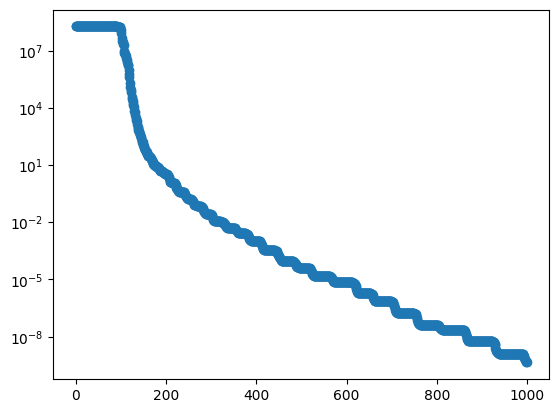

In [ ]:
import scipy

max_epochs = 1000
tol = 1e-8

np.random.seed(0)

epoch = 0

x = x_guess.copy()
Binv = np.eye(n)
grad = grad_jit(x)
history = []

while epoch < max_epochs and np.linalg.norm(grad) > tol:
    epoch += 1

    p = -Binv @ grad
    alpha = scipy.optimize.line_search(loss_jit, grad_jit, x, p)[0]
    if alpha is None:
        alpha = 1e-8
    
    x_new = x + alpha * p
    grad_new = grad_jit(x_new)

    s = x_new - x
    y = grad_new - grad
    rho = 1.0 / (y @ s)

    # Sherman-Morrison formula
    E = np.eye(n) - rho * jnp.outer(s, y)
    Binv = E @ Binv @ E.T + rho * jnp.outer(s, s)

    history.append(loss_jit(x_new))
    x = x_new
    grad = grad_new

plt.semilogy(history, "o-")